This is a playground for testing LSUV initialization. 

- As step 0, you need to reproduce this init on simple deep convnet on CIFAR10
- As step 1, you need to setup baselines for image fitting. They will be:
  - Default small guy
  - Very deep guy (9 layers)
  - Current SoTa

# The pipeline 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import lovely_tensors as lt
lt.monkey_patch()

In [2]:
# Orthonorm init code is taked from Lasagne
# https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
def svd_orthonormal(w):
    shape = w.shape
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.normal(0.0, 1.0, flat_shape)#w;
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    print (shape, flat_shape)
    q = q.reshape(shape)
    return q.astype(np.float32)


def orthogonal_weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            w_ortho = svd_orthonormal(m.weight.data.cpu().numpy())
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
        else:
            #nn.init.orthogonal(m.weight)
            w_ortho = svd_orthonormal(m.weight.data.cpu().numpy())
            #print w_ortho 
            #m.weight.data.copy_(torch.from_numpy(w_ortho))
            m.weight.data = torch.from_numpy(w_ortho)
            try:
                nn.init.constant_(m.bias, 0)
            except:
                pass
    return

In [3]:
from train_pipeline import *

In [4]:
import os
import torch
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

from IPython.display import clear_output

import lovely_tensors as lt
lt.monkey_patch()

cfg = load_cfg(overrides=[
    "+exp=07_splitnet_lsuv",
    "random_seed=[0]",
    'logging.logger._target_=spellbook.logging.wandb.WandbLogger',
    "image=cameraman",
    "+device=cuda:0",
])

print(OmegaConf.to_yaml(cfg))
# train(cfg)

image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    - 32
    - 32
    - 32
    - 32
    m: 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet_lsuv
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0



In [5]:
from train_pipeline import _train_seed

In [6]:
# _train_seed(cfg)

In [14]:
def splitnet_lsuv_init(self, batch_x):
    device = batch_x.device
    self = self.apply(orthogonal_weights_init)
    self = self.to(device)

    batch_x = self.encoding(batch_x)

    net = self.networks[0].net

    h = batch_x
    for layer in net:
        out, acts = layer.forward_with_activations(h)

        if True:
            print('*'*40)
            print('Working with layer', layer)
            x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts

            shape = h.shape[-1]
            for i, preact in enumerate([preact_tanh, preact_sigmoid, preact_sin, preact_cos]):
                print('Initial preact:', preact)
                from_i, to_i = i*shape, (i+1)*shape
                # W = layer.linear.weight.data[]

                mean = preact.mean().item()
                std = preact.std().item()

                layer.linear.bias.data[from_i:to_i] -= mean
                layer.linear.weight.data[from_i:to_i] /= std


            out, acts = layer.forward_with_activations(h)
            x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts
            for i, preact in enumerate([preact_tanh, preact_sigmoid, preact_sin, preact_cos]):
                print('After   preact:', preact)


        h = out
        
    return self

In [8]:
device = cfg["device"]

model_input, ground_truth, H, W = load_data(cfg)
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

out_features = ground_truth.shape[-1]
model = instantiate(cfg["model"], out_features=out_features)
model.to(device)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ParallelSplitNet(
  (encoding): GaussianEncoding()
  (networks): ModuleList(
    (0): SimpleSplitNet(
      (net): Sequential(
        (0): SplitLayer(
          (linear): Linear(in_features=256, out_features=128, bias=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (1): SplitLayer(
          (linear): Linear(in_features=32, out_features=128, bias=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (2): SplitLayer(
          (linear): Linear(in_features=32, out_features=128, bias=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (3): SplitLayer(
          (linear): Linear(in_features=32, out_features=128, bias=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (4): SplitLayer(
          (linear): Linear(in_features=32, out_features=128, bias=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (5): SplitLayer(
          (linear): Linear(in_features=32, out_features=128, bias=T

In [9]:
def _train_model(cfg, model, random_seed=0):
    seed_all(random_seed)
    print("Setting seed to", random_seed)
    is_debug = cfg.get("is_debug")

    project = str(cfg.logging.logger.project).replace(".jpg", "_jpg").replace(".png", "_png")

    if is_debug:
        project = "DEBUG__" + project

    logger = instantiate(
        cfg.logging.logger,
        project=project,
        group=cfg.logging.experiment_name,
        name=f"rs{random_seed}",
    )

    print("*" * 80)
    print("\n")
    print(OmegaConf.to_yaml(cfg))
    print()
    print("*" * 80)


    total_steps = cfg["total_steps"]
    steps_til_summary = cfg.logging["steps_till_summary"]
    batch_size = cfg.get('batch_size', None)

    total_params = count_parameters(model)

    logger.log_dict({"total_params": total_params})

    optimizer = instantiate(cfg.optimizer, params=model.parameters())

    for step in range(total_steps):
        if batch_size:
            idxs = torch.randint(0, model_input.shape[1], (batch_size,))
            model_input_batch = model_input[:, idxs]
            ground_truth_batch = ground_truth[:, idxs]
            if step < 2:
                print('model_input.shape', model_input.shape)
                print('model_input_batch.shape', model_input_batch.shape)
        else:
            model_input_batch = model_input
            ground_truth_batch = ground_truth

        model_output_batch = model(model_input_batch)
        mse, psnr = mse_and_psnr(model_output_batch, ground_truth_batch)
        loss = mse

        log_dic = {"step": step, "mse": mse.item(), "psnr": psnr.item()}
        logger.log_dict(log_dic)

        if not step % steps_til_summary:
            print(f"Step {step}, Total loss {loss:0.6f}")
            # img_grad_tensor = gradient(model_output, coords)
            # img_laplacian_tensor = laplace(model_output, coords)

            with torch.inference_mode():
                model_output = model(model_input)

            img = imagify_tensor(model_output, H, W)
            # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
            # img_laplacian = imagify_tensor(img_laplacian_tensor)

            colage = img
            plt.imshow(colage)
            plt.show()

            logger.log_image(colage, name="pred_image")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model, psnr

In [10]:
cfg.logging.experiment_name = 'splitnet_baseline'

In [11]:
cfg.logging.logger.project = 'splitnet_lsuv'

Setting seed to 0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


********************************************************************************


image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    - 32
    - 32
    - 32
    - 32
    m: 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: splitnet_lsuv
  steps_till_summary: 500
  experiment_name: splitnet_deep_baseline
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0


********************************************************************************
+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |    4096    |
|  networks.0.net.

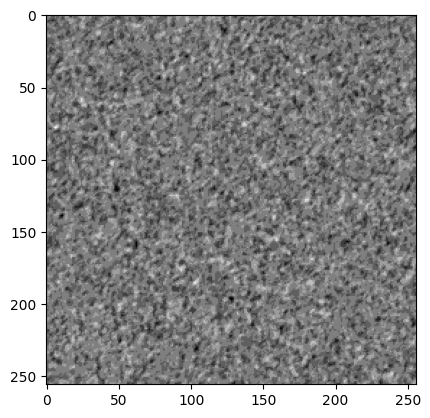

Step 500, Total loss 0.324159


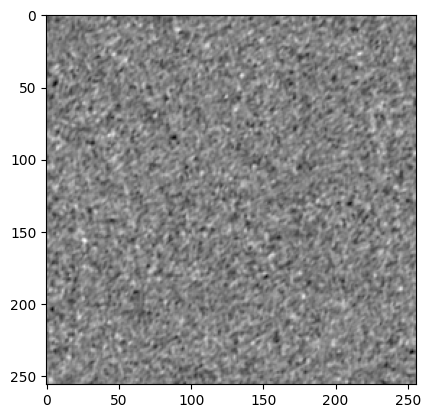

KeyboardInterrupt: 

In [12]:
cfg.logging.experiment_name = 'splitnet_deep_baseline'
_train_model(cfg, model)

(128, 256) (128, 256)
(128, 32) (128, 32)
(128, 32) (128, 32)
(128, 32) (128, 32)
(128, 32) (128, 32)
(128, 32) (128, 32)
(4, 32) (4, 32)
****************************************
Working with layer SplitLayer(
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)
Initial preact: tensor[1, 65536, 32] n=2097152 x∈[-3.394, 3.466] μ=0.003 σ=0.709 grad MulBackward0 cuda:0
Initial preact: tensor[1, 65536, 32] n=2097152 x∈[-3.223, 3.219] μ=0.000 σ=0.707 grad MulBackward0 cuda:0
Initial preact: tensor[1, 65536, 32] n=2097152 x∈[-3.562, 3.463] μ=0.004 σ=0.707 grad MulBackward0 cuda:0
Initial preact: tensor[1, 65536, 32] n=2097152 x∈[-3.390, 3.671] μ=0.001 σ=0.706 grad MulBackward0 cuda:0
After   preact: tensor[1, 65536, 32] n=2097152 x∈[-4.790, 4.886] μ=0.001 σ=1.000 grad MulBackward0 cuda:0
After   preact: tensor[1, 65536, 32] n=2097152 x∈[-4.548, 4.537] μ=-0.002 σ=0.997 grad MulBackward0 cuda:0
After   preact: tensor[1, 65536, 32] n=209715

mse,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▂▁▁
psnr,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▇██
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_params,▁
step,950
total_params,54148


********************************************************************************


image: cameraman
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  model_configs:
  - hidden_layers:
    - 32
    - 32
    - 32
    - 32
    - 32
    - 32
    m: 1.0
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: splitnet_lsuv
  steps_till_summary: 500
  experiment_name: splitnet_deep_lsuv
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0


********************************************************************************
+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |    4096    |
|  networks.0.net.1.li

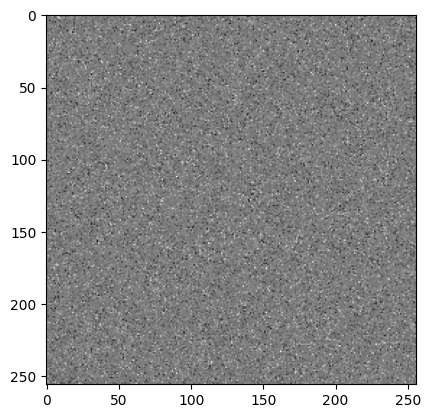

Step 500, Total loss 0.134143


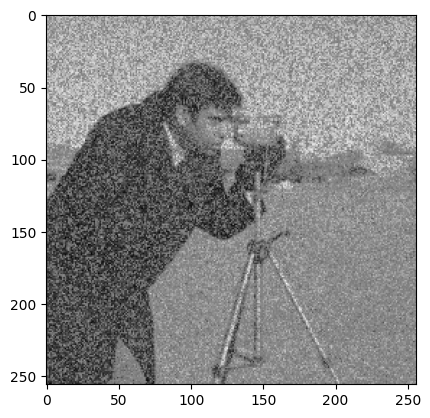

Step 1000, Total loss 0.101221


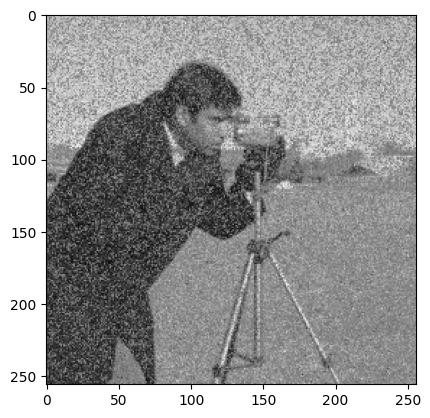

Step 1500, Total loss 0.081106


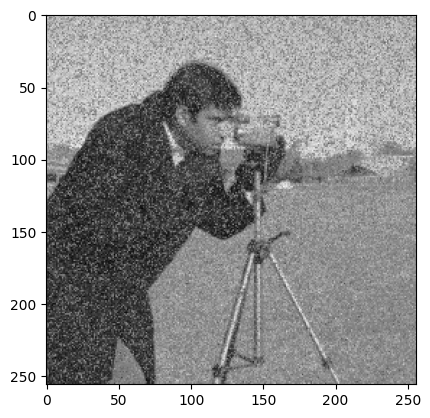

Step 2000, Total loss 0.067669


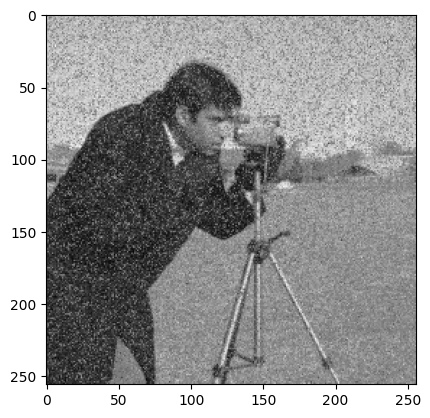

Step 2500, Total loss 0.057604


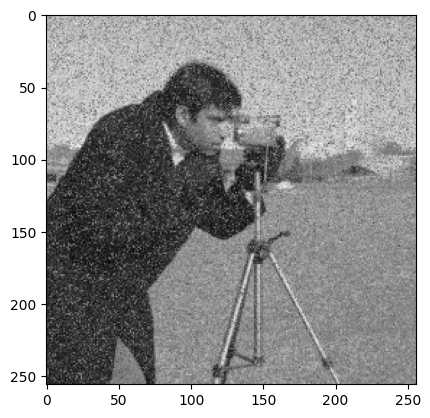

(ParallelSplitNet(
   (encoding): GaussianEncoding()
   (networks): ModuleList(
     (0): SimpleSplitNet(
       (net): Sequential(
         (0): SplitLayer(
           (linear): Linear(in_features=256, out_features=128, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
         (1): SplitLayer(
           (linear): Linear(in_features=32, out_features=128, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
         (2): SplitLayer(
           (linear): Linear(in_features=32, out_features=128, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
         (3): SplitLayer(
           (linear): Linear(in_features=32, out_features=128, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
         (4): SplitLayer(
           (linear): Linear(in_features=32, out_features=128, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
         (5): SplitLayer(
           (linear): Linear(in_features=3

In [15]:
model = instantiate(cfg["model"], out_features=out_features)
splitnet_lsuv_init(model, model_input)
cfg.logging.experiment_name = 'splitnet_deep_lsuv'
_train_model(cfg, model)

In [ ]:
break

# CNN baseline

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import lovely_tensors as lt
lt.monkey_patch()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_layers):
        super(SimpleCNN, self).__init__()
        
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            if i == 0:
                self.convs.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            else:
                self.convs.append(nn.Conv2d(32, 32, kernel_size=3, padding=1))
            
        self.fc1 = nn.Linear(32*32*32, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        for i in range(self.num_layers):
            x = self.convs[i](x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
valid_loader = DataLoader(testset, batch_size=64, shuffle=False)


In [ ]:
model = SimpleCNN(num_layers=2)  # Change num_layers to the number of layers you want

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_layers):
        super(SimpleCNN, self).__init__()

        self.num_layers = num_layers

        # Define the initial 3 standard conv layers
        layers = [
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ]

        num_channels = 128  # output channels from the last standard conv layer

        # Define 1x1 convolutions for the remaining layers
        for i in range(num_layers - 3):
            layers.append(nn.Conv2d(num_channels, num_channels, kernel_size=1))
            layers.append(nn.ReLU())

        self.conv_layers = nn.Sequential(*layers)

        final_size = 4  # size of the image after 3 max pooling operations (32 / 2**3)
        self.fc = nn.Linear(final_size*final_size*num_channels, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x


In [ ]:
model = SimpleCNN(num_layers=2)  # Change num_layers to the number of layers you want
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
! nvidia-smi

In [ ]:
device = 'cuda:0'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming that we have train_loader and valid_loader
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=5):
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        # Training phase
        model.train()
        model = model.to(device)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Validation phase
        model.eval()
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)

        # calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')

    # return the model and losses
    return model, train_losses, valid_losses

# Assuming that you have defined your model, criterion and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_layers=6).to(device)  # example number of layers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model, train_losses, valid_losses = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=5)

# Plot the training and validation loss curves
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(train_losses), label="Train")
plt.plot(np.array(valid_losses), label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
from lsuv import LSUVinit

In [ ]:
for i, data in enumerate(train_loader, 0):
    batch_x, labels = data
    break

In [ ]:
# Assuming that you have defined your model, criterion and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_layers=6).to(device)  # example number of layers
model = LSUVinit(model,inputs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model, train_losses, valid_losses = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=5)

# Plot the training and validation loss curves
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(train_losses), label="Train")
plt.plot(np.array(valid_losses), label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def print_weight_distr(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if hasattr(m, 'weight'):
            print(m.weight.data)
            display(m.weight.data.plt)
    return

In [ ]:
model = SimpleCNN(num_layers=6)

In [ ]:
self = model

def lsuv_init(self, batch_x):
    device = batch_x.device
    self = self.apply(orthogonal_weights_init)
    self = self.to(device)
    
    h = batch_x
    for layer in self.conv_layers:
        is_preact = (isinstance(layer, nn.Conv2d)) or (isinstance(layer, nn.Linear))
        out = layer(h)

        if is_preact:
            print('*'*40)
            print('Working with layer', layer)
            print('Initial out:', out)

            mean = out.mean().item()
            std = out.std().item()

            # subtract the mean from layer's output (zero mean)
            layer.bias.data -= mean

            # re-scale the layer's weights (unit variance)
            layer.weight.data /= std

            out = layer(h)
            print('Second out:', out)

            print('*'*40)


        h = out                     


In [ ]:
# Assuming that you have defined your model, criterion and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_layers=6).to(device)  # example number of layers
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
lsuv_init(model,inputs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model, train_losses, valid_losses = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=5)

# Plot the training and validation loss curves
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(train_losses), label="Train")
plt.plot(np.array(valid_losses), label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()